# Introductory EDA

The purpose of this notebook is to give a brief, high-level overview of our dataset as well as some of the tools of NLP.

# Setup

In [1]:
from toxic import common

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%xmode plain
%matplotlib inline
# sns.set_style('darkgrid')

from IPython.display import display

from collections import OrderedDict
from sklearn.neighbors import LocalOutlierFactor

Exception reporting mode: Plain


# The Data

In [2]:
train = common.gcs_to_df(blob='train.csv').set_index('id')
test = common.gcs_to_df(blob='test.csv').set_index('id')

In [3]:
ratings = train.loc[:, 'toxic':'identity_hate']
raw_comments = train['comment_text']
train['is_toxic'] = train.loc[:, 'toxic':].any(axis=1)

In [4]:
display(train.head())
display(test.head())

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
id,,,,,,,,
22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,True
27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,False
54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,False
77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,False
79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,False


,comment_text
id,
6044863,==Orphaned non-free media (Image:41cD1jboEvL. ...
6102620,::Kentuckiana is colloquial. Even though the ...
14563293,"Hello fellow Wikipedians,\nI have just modifie..."
21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
22982444,== [WIKI_LINK: Talk:Celts] ==


We have just under **96,000** training records, and **227,000** test records

''

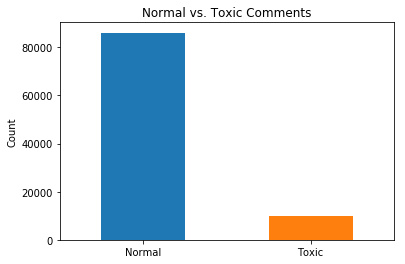

In [5]:
# Toxic vs. nontoxic
ax = train['is_toxic'].value_counts().plot(kind='bar')
ax.set_title('Normal vs. Toxic Comments')
ax.set_ylabel('Count')
ax.xaxis.set_ticklabels(['Normal', 'Toxic'], )
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
;

''

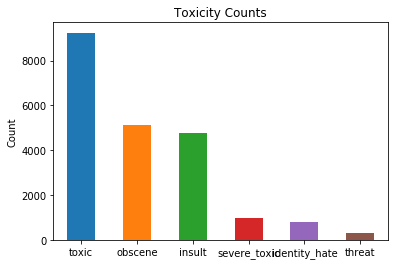

In [6]:
# Toxicity counts
ax = (ratings.sum(axis=0)
      .sort_values(ascending=False)
      .plot(kind='bar', title='Toxicity Counts'))
ax.set_ylabel('Count')
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
;

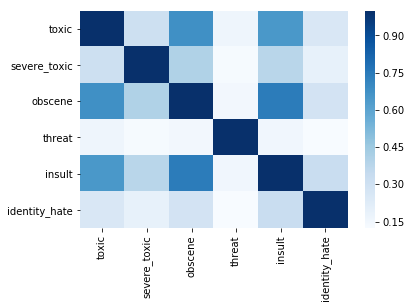

In [7]:
# Correlation heatmap
sns.heatmap(ratings.corr(), cmap='Blues');

In [8]:
ratings.corr().round(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.00,0.31,0.68,0.16,0.65,0.26
severe_toxic,0.31,1.00,0.40,0.13,0.38,0.19
obscene,0.68,0.40,1.00,0.15,0.74,0.29
threat,0.16,0.13,0.15,1.00,0.16,0.12
insult,0.65,0.38,0.74,0.16,1.00,0.33
identity_hate,0.26,0.19,0.29,0.12,0.33,1.00


Based on the above, there seems to a be a **strong dimension of obscene, toxic insults** in these comments data.... But note: threats are very rare.

Before going any further, let's take a look at a handful of comments:

# Illustrative Records and Wordclouds

In [9]:
from pprint import pprint
illustrations = train['comment_text'].sample(5, random_state=42*10)
for i in illustrations:
    print(i)
    print('='*80)

FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH TO USER JUJUBE!
FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH TO USER JUJUBE!
FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH TO USER JUJUBE!
FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH TO USER JUJUBE!
You know what else?  Because of the same type of bias that the guy is displaying, media reports are frequently biased.  It's like a bias echo chamber.  They write biased articles, then they come here and use Wikipedia to trumpet them. Clever, really, but unfair and untruthful.
How many niggers does it take to change a light bulb???
Treated him poorly huh? I didn't even use an ethnic slur or anything. This proves that he's a medical student from Pakistan: https://twitter.com/ashermadan/status/65290935558344705 and http://www.dailytimes.com.pk/default.asp?page=story_17-6-2004_pg7_37. You better ask him yourself and can't even 

Okay, so first pass impression...some people get really angry on the internet. But seriously, of the above five, three are what I would classify as toxic. The first is obscene and threatening, the third is racist and obscene, and the fourth may also be racist but at least seems to target someone personally. The second is scathing, but not toxic, and the last is nearly gibberish.

Notice: The first user spams the same message repeatedly, which is something that many toxic commenters could conceivably do.

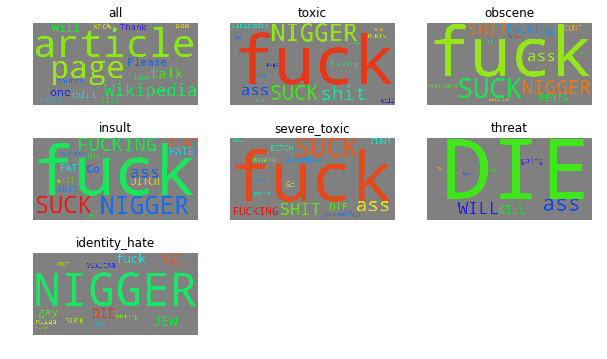

In [10]:
cloud = WordCloud(
    random_state=42, 
    min_font_size=10, 
    max_words=15, 
    background_color='gray', 
    prefer_horizontal=.999, 
    font_step=2, 
    relative_scaling=1)

plot_dict = OrderedDict([
    ('all',' '.join(train['comment_text'])),
    ('toxic',' '.join(train['comment_text'][train['toxic'] == 1])),
    ('obscene',' '.join(train.comment_text[train['obscene'] == 1])),
    ('insult',' '.join(train.comment_text[train['insult'] == 1])),
    ('severe_toxic',' '.join(train.comment_text[train['severe_toxic'] == 1])),
    ('threat',' '.join(train.comment_text[train['threat'] == 1])),
    ('identity_hate',' '.join(train.comment_text[train['identity_hate'] == 1])),
])

fig = plt.figure(1, figsize=(10,6))

for i,title in enumerate(plot_dict):
    ax = plt.subplot(int(str(33) + str(i + 1)))
    common.plot_wordcloud_to_axis(plot_dict[title], title, ax, cloud_obj=cloud)

plt.show()

# Text Vectorization

In [11]:
params = dict(
    ngram_range=(1,2),
    stop_words='english',
    max_features=1000,
    binary=False
)

counts = common.vectorize_text(raw_comments, output='df', vect='count', param_dict=params)

Fitting data...
Transforming data...
Sorting df cols...
Done


In [12]:
counts.head()

,article,wikipedia,page,talk,like,just,don,think,know,edit,...,propaganda,templates,indian,unsourced,noted,paper,effect,york,ahead,reasonable
id,,,,,,,,,,,,,,,,,,,,,
22256635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27450690,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
54037174,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
77493077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79357270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
counts.sum(axis=0).sort_values(ascending=False).head()

article      34410
wikipedia    29241
page         28205
talk         22402
like         17106
dtype: int64